Load Packages
===============

In [2]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets

Load Data:
===============

In [3]:
import codecs

In [4]:
download = datasets.FashionMNIST('./FMNIST/', train=True, download=True) 

100%|█████████▉| 26378240/26421880 [00:54<00:00, 605472.87it/s]

Extracting ./FMNIST/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FMNIST/FashionMNIST\raw



0it [00:00, ?it/s]
 56%|█████▌    | 16384/29515 [00:00<00:00, 83796.78it/s]
32768it [00:00, 44103.52it/s]                           

Extracting ./FMNIST/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FMNIST/FashionMNIST\raw



0it [00:00, ?it/s]
 99%|█████████▉| 4399104/4422102 [00:08<00:00, 510590.55it/s]

Extracting ./FMNIST/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FMNIST/FashionMNIST\raw




0it [00:00, ?it/s]

  0%|          | 0/5148 [00:00<?, ?it/s]

8192it [00:00, 12591.86it/s]            

Extracting ./FMNIST/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FMNIST/FashionMNIST\raw
Processing...
Done!


26427392it [01:10, 605472.87it/s]                              
4423680it [00:22, 510590.55it/s]                             

In [11]:
Datapath = 'FMNIST/FashionMNIST/raw/'

In [12]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [13]:
def parse_byte(b):
    if isinstance(b, str):
        return ord(b)
    return b

In [14]:
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(num_rows):
                row = []
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx += 1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1,784)

In [15]:
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        labels = [parse_byte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)

In [16]:
TrainImages = read_image_file(os.path.join(Datapath, 'train-images-idx3-ubyte'))
TrainLabels = read_label_file(os.path.join(Datapath, 'train-labels-idx1-ubyte'))
TestImages = read_image_file(os.path.join(Datapath, 't10k-images-idx3-ubyte'))
TestLabels = read_label_file(os.path.join(Datapath, 't10k-labels-idx1-ubyte'))

In [17]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])


In [18]:
use_gpu = torch.cuda.is_available()

Define the Autoencoder:
===============

In [19]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import copy


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
        
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): ReLU()
  )
)


Define Optimization Technique:
===============

In [20]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)

Train Autoencoder:
===========

In [23]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(TrainImages.size()[0]//BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs/255
        if use_gpu:
            inputs = Variable(inputs).cuda()
        else:
            inputs = Variable(inputs)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.data
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))
print('Finished Training')

At Iteration : 1 / 30  ;  Mean-Squared Error : 0.128251
At Iteration : 2 / 30  ;  Mean-Squared Error : 0.088749
At Iteration : 3 / 30  ;  Mean-Squared Error : 0.071165
At Iteration : 4 / 30  ;  Mean-Squared Error : 0.063504
At Iteration : 5 / 30  ;  Mean-Squared Error : 0.057229
At Iteration : 6 / 30  ;  Mean-Squared Error : 0.052703
At Iteration : 7 / 30  ;  Mean-Squared Error : 0.049458
At Iteration : 8 / 30  ;  Mean-Squared Error : 0.046539
At Iteration : 9 / 30  ;  Mean-Squared Error : 0.044796
At Iteration : 10 / 30  ;  Mean-Squared Error : 0.043614
At Iteration : 11 / 30  ;  Mean-Squared Error : 0.042054
At Iteration : 12 / 30  ;  Mean-Squared Error : 0.040984
At Iteration : 13 / 30  ;  Mean-Squared Error : 0.040251
At Iteration : 14 / 30  ;  Mean-Squared Error : 0.039369
At Iteration : 15 / 30  ;  Mean-Squared Error : 0.038914
At Iteration : 16 / 30  ;  Mean-Squared Error : 0.038536
At Iteration : 17 / 30  ;  Mean-Squared Error : 0.038047
At Iteration : 18 / 30  ;  Mean-Squared 

Testing Autoencoder Performance:
=================

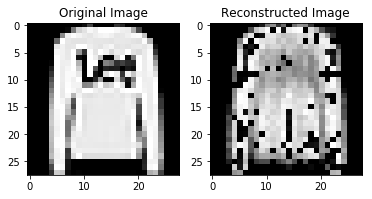

In [24]:
TestImg = torch.index_select(TestImages,0,torch.LongTensor([1]))
if use_gpu:
    outputImg = net(Variable((TestImg.double().cuda())/255)).data
    outputImg = (outputImg*255).byte()
    outputImg = outputImg.view(-1,28,28).cpu()
else:
    outputImg = net(Variable((TestImg.double())/255)).data
    outputImg = (outputImg*255).byte()
    outputImg = outputImg.view(-1,28,28)

TestImg = TestImg.view(-1,28,28)

fig = plt.figure()
plot=fig.add_subplot(1,2,1)
img = np.array(TestImg.numpy())[0]
plot.set_title('Original Image')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,2,2)
img = np.array(outputImg.numpy())[0]
plot.set_title('Reconstructed Image')
imgplot = plt.imshow(img,cmap='gray')
plt.show()



Encoder Weights Visualization:
=======================

In [25]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)

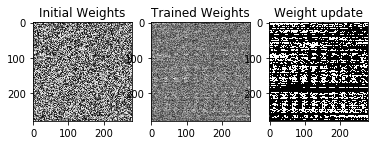

In [26]:
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5


if use_gpu:
    init_weights = init_weights.view(-1,280,280).byte().cpu()
    trained_weights = trained_weights.view(-1,280,280).byte().cpu()
else:
    init_weights = init_weights.view(-1,280,280).byte()
    trained_weights = trained_weights.view(-1,280,280).byte()

d_weights = init_weights - trained_weights 

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

Remove Decoder and Add Classification Layer: 
================================

In [27]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10),nn.LogSoftmax()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


Define Optimizer:
================================

In [28]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Train Classifier:
===========

In [31]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(TrainImages.size()[0]//BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).long()
        inputs = inputs/255
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.data
    inputs = TestImages.double()/255
    if use_gpu:
        inputs = Variable(inputs.cuda())
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu()
    else:
        inputs = Variable(inputs)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
    correct = 0
    total = 0
    total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    print('At Iteration: %d / %d  ;  Training Loss: %f ; Testing Acc: %f '%(epoch + 1,iterations,runningLoss/
                                                                            (TrainImages.size()[0]/
                                                                             BatchSize),(100 * correct/ float(total))))
print('Finished Training')

At Iteration: 1 / 30  ;  Training Loss: 1.181214 ; Testing Acc: 71.000000 
At Iteration: 2 / 30  ;  Training Loss: 0.694062 ; Testing Acc: 76.000000 
At Iteration: 3 / 30  ;  Training Loss: 0.610011 ; Testing Acc: 79.000000 
At Iteration: 4 / 30  ;  Training Loss: 0.562198 ; Testing Acc: 80.000000 
At Iteration: 5 / 30  ;  Training Loss: 0.530239 ; Testing Acc: 80.000000 
At Iteration: 6 / 30  ;  Training Loss: 0.507263 ; Testing Acc: 81.000000 
At Iteration: 7 / 30  ;  Training Loss: 0.490046 ; Testing Acc: 81.000000 
At Iteration: 8 / 30  ;  Training Loss: 0.476550 ; Testing Acc: 82.000000 
At Iteration: 9 / 30  ;  Training Loss: 0.465461 ; Testing Acc: 82.000000 
At Iteration: 10 / 30  ;  Training Loss: 0.455976 ; Testing Acc: 82.000000 
At Iteration: 11 / 30  ;  Training Loss: 0.447570 ; Testing Acc: 82.000000 
At Iteration: 12 / 30  ;  Training Loss: 0.439895 ; Testing Acc: 82.000000 
At Iteration: 13 / 30  ;  Training Loss: 0.432960 ; Testing Acc: 83.000000 
At Iteration: 14 / 30

Encoder Weights Visualization:
=======================

In [32]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)

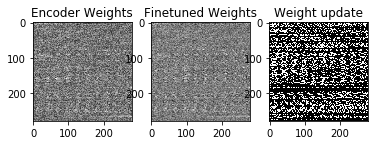

In [33]:
cll_weights = (1 + cll_weights)*127.5
cll_weights_ft = (1 + cll_weights_ft)*127.5

if use_gpu:
    cll_weights = cll_weights.view(-1,280,280).byte().cpu()
    cll_weights_ft = cll_weights_ft.view(-1,280,280).byte().cpu()
else:
    cll_weights = cll_weights.view(-1,280,280).byte()
    cll_weights_ft = cll_weights_ft.view(-1,280,280).byte()

d_weights = cll_weights - cll_weights_ft

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(cll_weights.numpy())[0]
plot.set_title('Encoder Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(cll_weights_ft.numpy())[0]
plot.set_title('Finetuned Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

Classifier Weights Visualization:
=======================

In [34]:
trained_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

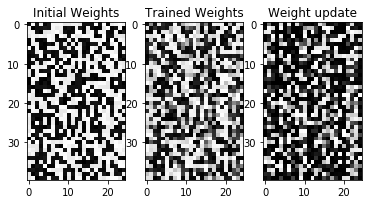

In [35]:
init_classifier_weights = (1 + init_classifier_weights)*255
trained_classifier_weights = (1 + trained_classifier_weights)*255

if use_gpu:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte().cpu()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte().cpu()
else:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte()

d_weights = init_classifier_weights - trained_classifier_weights

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_classifier_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_classifier_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()